In [1]:
# ! pip install opencv-python
# ! pip install pyhocon
# ! pip install plotly

In [2]:
# Import necessary libraries
import os
import numpy as np
from google.cloud import storage
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
    Activation, BatchNormalization, ReLU, Concatenate, Flatten, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import glob
import log
import utils as ut
import plotly.express as px

In [3]:
@ut.timer
def list_blobs_with_prefix(bucket_name, prefix):
    storage_client = storage.Client()
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix)
    return [blob.name for blob in blobs]


def _get_bucket(bucket_name):
    storage_client = storage.Client()
    return storage_client.bucket(bucket_name)


def _read_image_from_gcs(bucket, blob_path):
    filename = storage.Blob(blob_path, bucket)
    file_as_bytes = filename.download_as_bytes()
    nparr = np.frombuffer(file_as_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img


# 1. Download and load the data
@ut.timer
def load_data(bucket_name, filenames):
    bucket = _get_bucket(bucket_name)
    images = []
    for img_path in filenames:
        img = _read_image_from_gcs(bucket, img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        img = img / 255.0
        images.append(img)
    images = np.array(images)
    return images


# 2. Preprocess the data
@ut.timer
def preprocess_data(images, NOISE_FACTOR):
    images_noisy = images + NOISE_FACTOR * np.random.normal(loc=0.0, scale=1.0, size=images.shape) 
    images_noisy = np.clip(images_noisy, 0., 1.)
    return images_noisy


# 3. Split the data into training, validation, and test sets
@ut.timer
def split_data(images_clean, images_noisy):
    # Split into train and rest
    images_clean_train, images_clean_rest, images_noisy_train, images_noisy_rest = train_test_split(images_clean, images_noisy, test_size=0.2, random_state=0)
    # Further split rest into validation and test
    images_clean_val, images_clean_test, images_noisy_val, images_noisy_test = train_test_split(images_clean_rest, images_noisy_rest, test_size=0.5, random_state=0)
    return images_clean_train, images_clean_val, images_clean_test, images_noisy_train, images_noisy_val, images_noisy_test


@ut.timer
def create_model(optimizer, loss):
    # Encoder
    input_img = Input(shape=(64, 64, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # At this point the representation is (16, 16, 64)
    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    # This model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    # compile the model
    autoencoder.compile(optimizer=optimizer, loss=loss)
    return autoencoder

# 5. Compile and train the model
@ut.timer
def train_model(model, images_clean_train, images_noisy_train, images_clean_test, images_noisy_test,
                           epochs, batch_size):
    model.compile(optimizer='adam', loss='mse')
    model.fit(images_noisy_train, images_clean_train, validation_data=(images_noisy_test, images_clean_test), epochs=epochs, batch_size=batch_size)

    
def evaluate_model(model, images_noisy_test, images_clean_test):
    test_loss = model.evaluate(images_noisy_test, images_clean_test, verbose=1)
    logger.info(f"Test loss (MSE): {test_loss}")
    images_denoised = model.predict(images_noisy_test)
    return images_denoised
    
    
@ut.timer
def plot_results(images_noisy_test, images_clean_test, images_denoised, bucket_name, prefix):
    storage_client = storage.Client()
    # Compare clean, noisy, and denoised images
    for i in range(5):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        ax[0].imshow(images_clean_test[i])
        ax[0].axis('off')
        ax[0].set_title('Clean')

        ax[1].imshow(images_noisy_test[i])
        ax[1].axis('off')
        ax[1].set_title('Noisy')

        ax[2].imshow(images_denoised[i])
        ax[2].axis('off')
        ax[2].set_title('Denoised')

        # Save figure to a file
        plt.savefig('temp.png')
        plt.show()
        
        # Upload file to GCS
        bucket = storage_client.get_bucket(bucket_name)
        blob = bucket.blob(f'{prefix}/{ut.get_current_dt()}_{i}.png')
        blob.upload_from_filename('temp.png')
        # Delete the local file
        os.remove('temp.png')
        
        
def main():
    faces_filenames = list_blobs_with_prefix(bucket_name=conf.gcp.bucket_name, prefix=conf.gcp.paths.raw_lfwcrop_color_faces)
    images_clean = load_data(conf.gcp.bucket_name, faces_filenames[:3000])
    images_noisy = preprocess_data(images_clean, conf.gcp.a2_q3_model_params.NOISE_FACTOR)
    images_clean_train, images_clean_val, images_clean_test, images_noisy_train, images_noisy_val, images_noisy_test = split_data(images_clean, images_noisy)
    model = create_model(conf.gcp.a2_q3_model_params.optimizer, conf.gcp.a2_q3_model_params.loss)
    train_model(model, images_clean_train, images_noisy_train, images_clean_val, images_noisy_val,
                           conf.gcp.a2_q3_model_params.epochs, conf.gcp.a2_q3_model_params.batch_size)
    images_denoised = evaluate_model(model, images_noisy_test, images_clean_test)
    plot_results(images_noisy_test, images_clean_test, images_denoised,
                conf.gcp.bucket_name, conf.gcp.paths.result_denoising)
    

In [4]:
logger = log.get_logger(__name__)
conf = ut.load_config()
# Set random seeds for reproducability
np.random.seed(conf.gcp.seed)
tf.random.set_seed(conf.gcp.seed)

01-May-23 00:47:21 - INFO - Starting 'load_config'.
01-May-23 00:47:21 - INFO - Finished 'load_config' in 0.0953 secs.


01-May-23 00:47:21 - INFO - Starting 'list_blobs_with_prefix'.
01-May-23 00:47:24 - INFO - Finished 'list_blobs_with_prefix' in 2.3631 secs.
01-May-23 00:47:24 - INFO - Starting 'load_data'.
01-May-23 00:51:50 - INFO - Finished 'load_data' in 266.0875 secs.
01-May-23 00:51:50 - INFO - Starting 'preprocess_data'.
01-May-23 00:51:51 - INFO - Finished 'preprocess_data' in 1.7835 secs.
01-May-23 00:51:51 - INFO - Starting 'split_data'.
01-May-23 00:51:52 - INFO - Finished 'split_data' in 0.2309 secs.
01-May-23 00:51:52 - INFO - Starting 'create_model'.
2023-05-01 00:51:52.240782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-01 00:51:52.240834: W tensorflow/stream_executor/cuda/cuda_driver.

Epoch 1/20
75/75 [==============================] - 27s 350ms/step - loss: 0.0136 - val_loss: 0.0044
Epoch 2/20
75/75 [==============================] - 27s 355ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 3/20
75/75 [==============================] - 26s 348ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 4/20
75/75 [==============================] - 24s 326ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/20
75/75 [==============================] - 24s 326ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/20
75/75 [==============================] - 26s 349ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/20
75/75 [==============================] - 27s 358ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/20
75/75 [==============================] - 26s 348ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/20
75/75 [==============================] - 25s 328ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/20
75/75 [==============================] - 26s 350ms/step - loss: 0.0015 - val_lo

01-May-23 01:00:30 - INFO - Finished 'train_model' in 518.5103 secs.


10/10 [==============================] - 1s 70ms/step - loss: 0.0012


01-May-23 01:00:31 - INFO - Test loss (MSE): 0.001171907759271562
01-May-23 01:00:32 - INFO - Starting 'plot_results'.


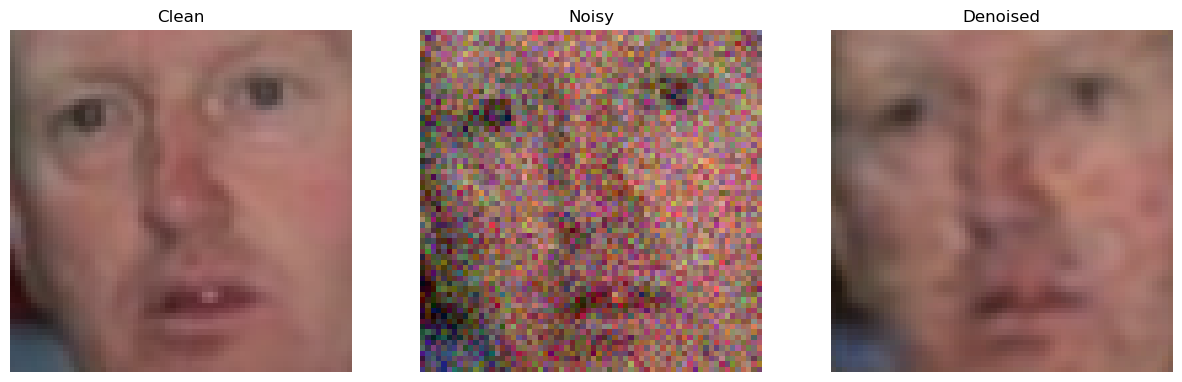

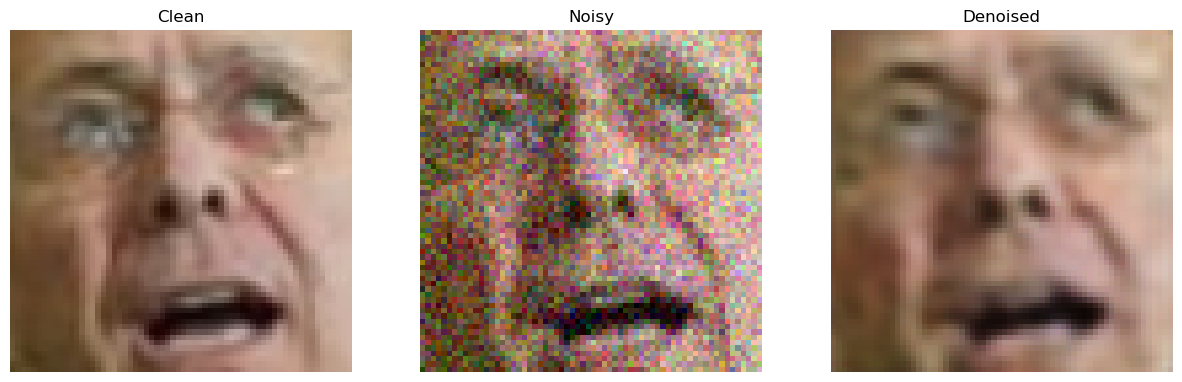

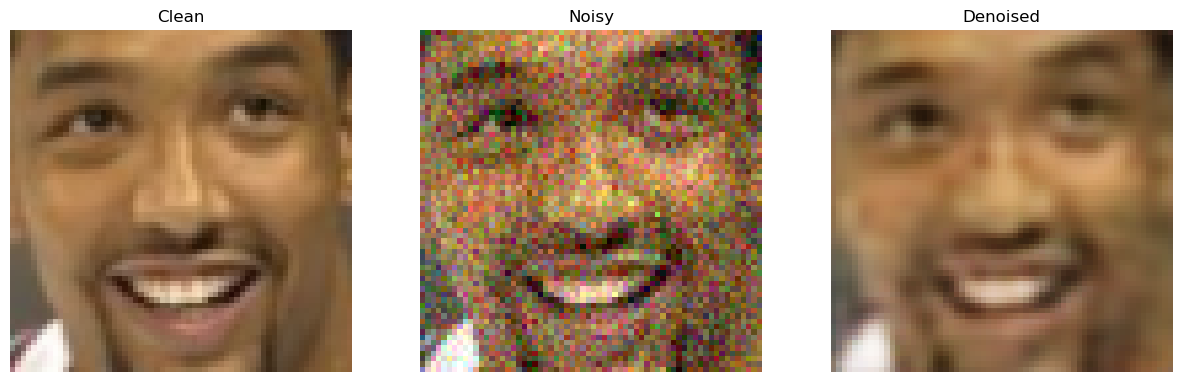

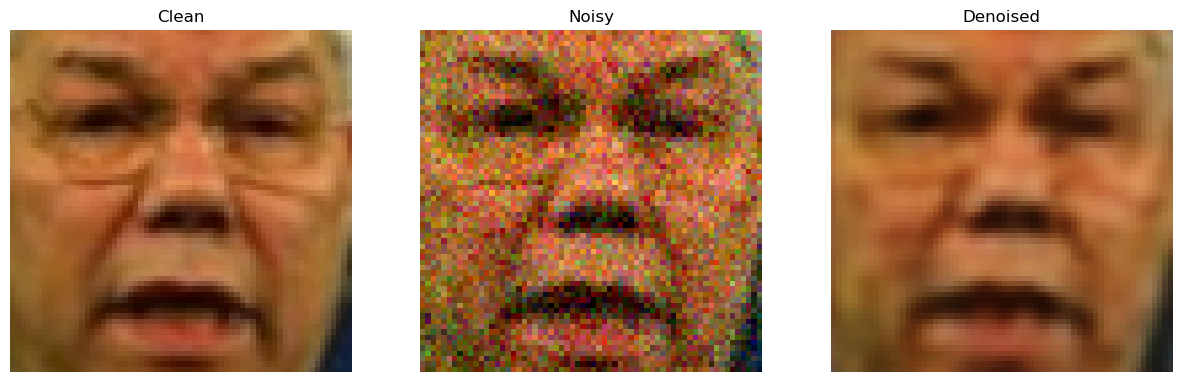

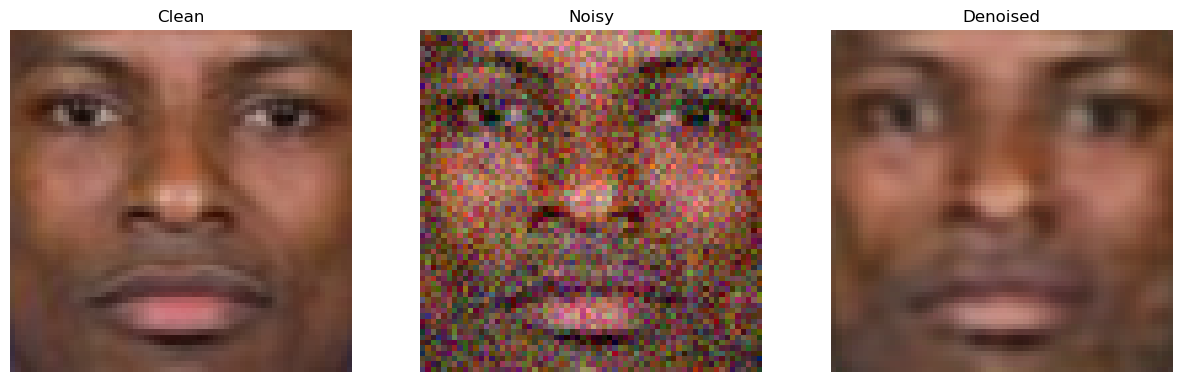

01-May-23 01:00:34 - INFO - Finished 'plot_results' in 2.1212 secs.


In [5]:
main()